This Colab is the practical part of the 13th Session "TensorFlow Introduction" (guest lecture by Andreas Steiner) in François Fleuret's Deep Learning Course (https://fleuret.org/ee559)

Please refer to the handout for instructions about the exercises:

https://docs.google.com/document/d/1dWLM0bRu0qW_B2cKJSisZghUBQ-x-ZBE19TWKmvv_hQ

##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 0 Setup

## 0.1 Authenticate

We need to access both GCS (Google cloud storage) for getting the prepared QuickDraw data and Google Drive for storing data beyond the short lifetime of the virtual machine running the kernel for this Colab.

Below cell runs the authentication workflow for both GCS & Drive. Needs to be re-executed every time the VM is restarted.

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## 0.2 Install & import

By default, TensorFlow 1.13 is installed. But we're going to use the alpha version of TensorFlow 2.0 which first needs to be installed on the machine.

In [ ]:
# Let's install GPU that runs fine on both CPU and GPU.
!pip install tf-nightly-gpu-2.0-preview --verbose

Created temporary directory: /tmp/pip-ephem-wheel-cache-vvm6fh3_
Created temporary directory: /tmp/pip-req-tracker-cv4k87le
Created requirements tracker '/tmp/pip-req-tracker-cv4k87le'
Created temporary directory: /tmp/pip-install-rys14025
Cleaning up...
Removed build tracker '/tmp/pip-req-tracker-cv4k87le'


In [ ]:
import tensorflow as tf
import os
if int(tf.__version__.split('.')[0]) < 2:
    tf.enable_eager_execution()
(tf.__version__, tf.test.is_gpu_available(), 'COLAB_TPU_ADDR' in os.environ)

('2.0.0-dev20190521', True, False)

In [ ]:
import json, os, time

from matplotlib import pyplot as plt
import numpy as np

# We will store models on Drive.
models_path = '/content/gdrive/My Drive/ee559/session13/models'

# 1 Colab

If you use Python on a regular basis, you're probably already familiar with [Jupyter Notebook](https://jupyter.org/). Colab is a basically a Jupyter notebook in the cloud : the notebook itself is stored as a Google doc (with revision history, access control, comments, and concurrent editing) and the Python kernel runs in a dynamically allocated virtual machine on Google cloud.

The web UI is also somewhat improved, including a left-hand drawer with table of contents, snippets, and remote file browser. There are also custom extensions, "forms" and much more.

## 1.1 Important shortcuts

Action | Colab Shortcut | Jupyter Shortcut
---|---|---
Executes current cell | `<CTRL-ENTER>` | `<CTRL-ENTER>`
Executes current cell and moves to next cell | `<SHIFT-ENTER>` | `<SHIFT-ENTER>`
Insert cell above | `<CTRL-M> <A>` | `<A>`
Append cell below | `<CTRL-M> <B>` | `<B>`
Shows searchable command palette | `<CTRL-SHIFT-P>` | `<CTRL-SHIFT-P>`
Convert cell to code | `<CTRL-M> <Y>` | `<Y>`
Convert cell to Markdown | `<CTRL-M> <M>` | `<M>`
Autocomplete | `<TAB>` | `<TAB>`
Goes from edit to "command" mode | `<ESC>` | `<ESC>`
Goes from "command" to edit mode | `<ENTER>` | `<ENTER>`
Show keyboard shortcuts | `<CTRL-M> <H>` | `<H>`
<p align="center"><b>Note:</b> On OS X you can use `<COMMAND>` instead of `<CTRL>`</p>

Give it a try!

## 1.1 API documentation

In [ ]:
# Place the caret inside the parens and hit <TAB> to get a popover displaying
# the API documentation. So useful it merits its very own section in this Colab.
tf.GradientTape()

## 1.2 About runtimes

Colab provides multiple runtimes with different hardware accelerators:

*   CPU (default)
*   GPU
*   TPU

which can be selected by choosing the `"Runtime"` tab above and then `"Change runtime type"`.

Please be aware that selecting a new runtime will assign a new virtual machine (VM).
In general, assume that any changes you make to the VM environment including data storage are **ephemeral**. Particularly, this might require to **execute previous cells again** as their content is unknown to a new runtime otherwise. 

Let's take a closer look at one of such provided VMs.


In [ ]:
# Display how long the system has been running.
!uptime

 07:27:18 up 17 min,  0 users,  load average: 0.01, 0.07, 0.08


In [ ]:
# Display available and used memory.
!free -h
print("-"*70)
# Display the CPU specification.
!lscpu
print("-"*70)
# Display the GPU specification (if available).
!(nvidia-smi | grep -q "has failed") && echo "No GPU found!" || nvidia-smi 

              total        used        free      shared  buff/cache   available
Mem:            12G        764M        5.8G        4.9M        6.1G         11G
Swap:            0B          0B          0B
----------------------------------------------------------------------
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2300.000
BogoMIPS:            4600.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse3

## 1.3 Start TensorBoard & tunnel

We can start arbitrary programs in our VM. One particularly interesting program is [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) allows to track metrics during training (and much more).

Unfortunately, the VM's ports cannot be accessed directly from the web, so we have to tunnel them via a service. The example below uses https://ngrok.com/ whose utility first must be downloaded.

In [ ]:
# Download & unzip ngrok
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip
!ls -lh ./ngrok

--2019-05-22 07:28:21--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.86.186.182, 34.196.237.103, 52.3.53.115, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.86.186.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16648024 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  15.88M  15.4MB/s    in 1.0s    

2019-05-22 07:28:22 (15.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [16648024/16648024]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
-rwxr-xr-x 1 root root 34M May 19 10:07 ./ngrok


In [66]:
# This cell (re)starts TensorBoard & forward the port using ngrok.

# Stop previously started processes, if any.
!pkill tensorboard; pkill ngrok
# Make sure ngrok was installed locally in previous cell.
assert os.system('./ngrok --help') == 0
# Start TensorBoard.
get_ipython().system_raw(
    'tensorboard --logdir "./tensorboard" --host 0.0.0.0 --port 6006 &'
)
# Forward port.
get_ipython().system_raw('./ngrok http 6006 &')
# Give some time to start up.
!sleep 1
# Output external address (ngrok's web interface listens at 4004).
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://b1fb58e8.ngrok.io


Note that you can also start this process in a separate Colab running on the same VM : Create a new Colab "File/New Python 3 Notebook" copy above cell and paste it into the new Colab. Since both Colabs run in the same VM (unless they have a different setting "Runtime/Change runtime type") you don't need to download ngrok, it is already in the current working directory.

### 1.4 More ...

We've only covered the very basics about Colab in above sections. If you're interested in knowing more, please check out the Colab [0_colab.ipynb](https://colab.research.google.com/github/tensorflow/workshops/blob/master/extras/amld/notebooks/solutions/0_colab.ipynb) from the AMLD workshop, or walk through some of the example Colabs (File/Open -> select from "Examples" tab).

(But try not to spend more than 10 minutes overall in this "Colab" section)

# 2 Predicting QuickDraw

In this section we will train some simple models on [QuickDraw data](https://quickdraw.withgoogle.com/data/). The purpose is to familiarize you with basic TensorFlow API and Keras, so you can come back to these examples later on and use them as a skeleton when building your own models.

The code is a short summary the following AMLD Workshop notebooks - go there for more in depth examples:

https://colab.research.google.com/github/tensorflow/workshops/blob/master/extras/amld/notebooks/solutions/1_data.ipynb

https://colab.research.google.com/github/tensorflow/workshops/blob/master/extras/amld/notebooks/solutions/2_keras.ipynb

https://colab.research.google.com/github/tensorflow/workshops/blob/master/extras/amld/notebooks/solutions/3_eager.ipynb

https://colab.research.google.com/github/tensorflow/workshops/blob/master/extras/amld/notebooks/solutions/4_predict.ipynb

(Be aware that those notebooks are still using TensorFlow 1.13)

## 2.1 Read data

Today we're using a prepared dataset in [protocol buffer](https://developers.google.com/protocol-buffers/docs/pythontutorial) format on Cloud. Preparing your own data is an interesting topic and described in some length in the [AMLD workshop](https://github.com/tensorflow/workshops/tree/master/extras/amld).

If you want to play around with other data you should first check out the [list of  datasets](https://www.tensorflow.org/datasets/datasets).

In [ ]:
# Let's use a relatively small dataset with only 11 classes for developing our
# models. We will move to a larger set for the Sock Competition.
# - 50k training examples, including pickled DataFrame
data_path = 'gs://amld-datasets/zoo_img_50k'

print('https://console.cloud.google.com/storage/browser/' + data_path.split('//')[1])

https://console.cloud.google.com/storage/browser/amld-datasets/zoo_img_50k


In [ ]:
# Labels are represented as integers in these examples. The "labels.txt" files
# translates these integers to descriptive words.
labels = [label.strip() for label in tf.io.gfile.GFile('{}/labels.txt'.format(data_path))]
print('All labels in the dataset:', ' '.join(labels))

# The examples re stored in a format that simply concatenates records one by
# one. There is no information about the number of records contained. That
# information was stored separately after generation in the "counts.json".
counts = json.load(tf.io.gfile.GFile('{}/counts.json'.format(data_path)))
print("Splits sizes:", counts)

All labels in the dataset: camel crocodile dolphin elephant flamingo giraffe kangaroo lion monkey penguin rhinoceros
Splits sizes: {'eval': 10000, 'test': 20000, 'train': 50000}


In [ ]:
# This dictionary describes which features to read from the protocol buffer.
# The protocol buffers contain additional features that we don't need below.
feature_spec = {
    # The label is a single number (referring to names in "labels.txt").
    'label': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
    # The images are stored as a list of numbers of type int64. Here we can
    # specify to reshape the list on reading to a tensor of shape [64, 64].
    'img_64': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.int64),
}

def parse_record(serialized_example):
    features = tf.io.parse_single_example(serialized_example, feature_spec)
    return (
        tf.cast(features['img_64'], tf.float32) / 255,
        tf.one_hot(features['label'], len(labels)),
    )

def make_ds(which, batch_size=100):
    # The tf.io.gfile module provides transparent access to files on Gogole Cloud
    # Storage (GCS).
    ds = tf.data.TFRecordDataset(tf.io.gfile.glob('{}/{}-*'.format(data_path, which)))
    ds = ds.map(parse_record).batch(batch_size)
    return ds, counts[which] // batch_size

ds_train, train_steps = make_ds('train')
# Note that preloading the training shuffle buffer adds some latency when
# accessing the data (you can try below cells without shuffling for comparison).
ds_train = ds_train.shuffle(buffer_size=1000).repeat()
ds_eval, eval_steps = make_ds('eval')

# So we have:
# Nr of examples in {train,eval} set = batch_size * {train,eval}_steps.

train_steps, eval_steps

(500, 100)

In [ ]:
# The dataset is iterable. Every iteration returns a batch of tensors parsed
# from a batch of tf.Example records. We only return the img_64 feature (x)
# and the one-hot encoded label (y) - see return value of parse_record().
for x, y in ds_train:
    break
x.shape, y.shape

(TensorShape([100, 64, 64]), TensorShape([100, 11]))

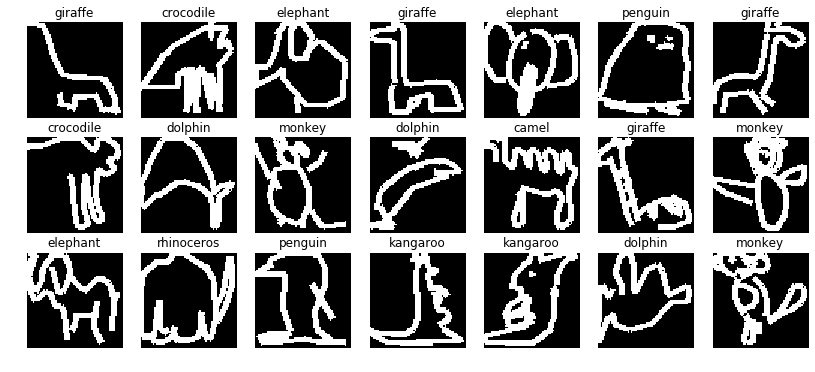

In [ ]:
# Inspect some data.
cols, rows = 7, 3
plt.figure(figsize=(2*cols, 2*rows))
for i in range(cols * rows):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x[i], cmap='gray')
    plt.axis('off')
    plt.title(labels[y[i].numpy().argmax()])

## 2.2 Linear model

We train a simple linear model from raw pixel data:

$$ y = \text{softmax}( Wx + b ) $$

In this section we write a custom training loop and use basic TensorFlow operations for training. Usually you don't need this flexibility and would train the model using some abstractions (see next sections where we use Keras for achieving the same task with much less code).

In [ ]:
# We provide an initializer when creating the variable.
W = tf.Variable(tf.random.normal(shape=(x.shape[1] * x.shape[2], y.shape[1])))
b = tf.Variable(tf.random.normal(shape=(y.shape[1], )))
W.shape, b.shape

(TensorShape([4096, 11]), TensorShape([11]))

In [ ]:
# YOUR ACTION REQUIRED:
# Adjust the training below to use a decaying learning rate / step size instead
# of using a fixed rate of 0.01.
# (Using a decaying learning rate is often a good idea to make quick progress in
#  the beginning but avoid making too big changes to already tuned parameters.)




# Record values for loss and accuracy for plotting purposes.
losses = []
accs = []
lr=0.01
decay=1e-7
# Train for two epochs.
epochs = 2
for step, (x, y) in enumerate(ds_train):
    if step >= epochs * train_steps:
        break
    # Compute predictions from input and weights.
    with tf.GradientTape() as tape:
        logits = tf.matmul(tf.reshape(x, (x.shape[0], -1)), W) + b
        loss = tf.nn.softmax_cross_entropy_with_logits(y, logits)
    losses.append(loss.numpy().mean())
    W_grad, b_grad = tape.gradient(loss, (W, b))

    # Gradient descent.
    W.assign_add(-lr * W_grad)
    b.assign_add(-lr * b_grad)
    lr=lr-decay
    if(lr<0):
      lr=0
    # Compute accuracy.
    good_preds = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
    acc = tf.reduce_mean(tf.cast(good_preds, tf.float32))
    accs.append(acc.numpy())
    # Prove we didn't freeze...
    if step and step % 100 == 0:
        print('step={:4d} loss={:2.3f} acc={:.3f}'.format(
            step, np.mean(losses[-100:]), np.mean(accs[-100:])))

step= 100 loss=23.844 acc=0.341
step= 200 loss=18.252 acc=0.416
step= 300 loss=17.465 acc=0.432
step= 400 loss=17.159 acc=0.443
step= 500 loss=16.347 acc=0.449
step= 600 loss=14.970 acc=0.470
step= 700 loss=14.475 acc=0.463
step= 800 loss=14.558 acc=0.465
step= 900 loss=15.164 acc=0.461


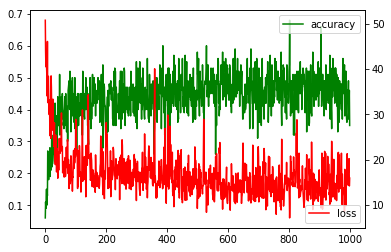

In [ ]:
# Plot accuracy (should go up) and loss (should go down).
# Note large variance from one batch to another.
plt.plot(accs, 'g', label='accuracy')
plt.legend(loc='upper right')
plt.grid(False)
plt.twinx().plot(losses, 'r', label='loss')
plt.legend(loc='lower right')
plt.grid(False)

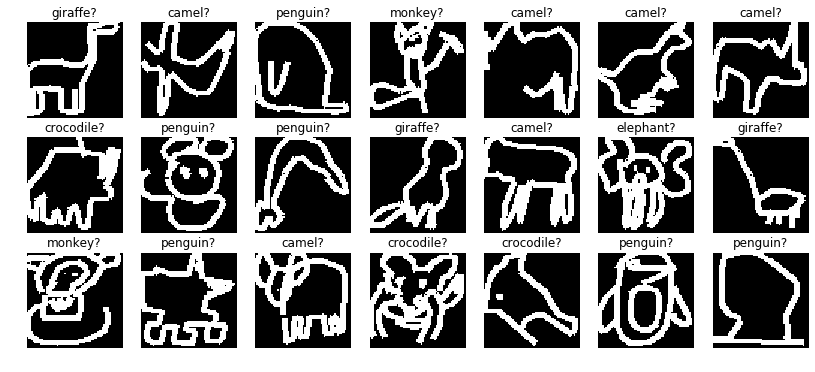

In [ ]:
# Analyze some predictions.
cols, rows = 7, 3
plt.figure(figsize=(2*cols, 2*rows))
for i in range(cols * rows):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x[i], cmap='gray')
    plt.axis('off')
    pred = tf.nn.softmax(tf.matmul(tf.reshape(x[i: i + 1], (1, -1)), W) + b)
    plt.title(labels[pred.numpy().argmax()] + '?')

## 2.3 Keras to the rescue

Keras is a clean API for defining neural networks at the layer level.

A model is defined as a stack of [Keras layers](https://keras.io/layers/about-keras-layers/).

In [ ]:
linear_model = tf.keras.Sequential()
# Need to specify the input shape for the first layer.
# Note that the batch dimension is NOT specified in the input_shape.
linear_model.add(tf.keras.layers.Flatten(input_shape=(64, 64,)))
# For all consecutive layers, the input shape is determined by the output shape
# of the preceding layer.
# A linear model is simply a single dense layer.
linear_model.add(tf.keras.layers.Dense(len(labels), activation='softmax'))

linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.categorical_accuracy])

linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                45067     
Total params: 45,067
Trainable params: 45,067
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Let's train the model for two epochs.

# YOUR ACTION REQUIRED:
# Use dataset from above and train and evaluate using the `.fit()` method.
# Do you get comparable results to the previous section?
linear_model.fit(ds_train,
               validation_data=ds_eval,
               steps_per_epoch=train_steps,
               validation_steps=eval_steps,
               epochs=2,
               verbose=True)

Epoch 1/2
500/500 [==============================] - 37s 73ms/step - loss: 1.2214 - accuracy: 0.6030 - categorical_accuracy: 0.6030 - val_loss: 1.3577 - val_accuracy: 0.5654 - val_categorical_accuracy: 0.5654
Epoch 2/2
500/500 [==============================] - 15s 31ms/step - loss: 1.1835 - accuracy: 0.6133 - categorical_accuracy: 0.6133 - val_loss: 1.3525 - val_accuracy: 0.5685 - val_categorical_accuracy: 0.5685


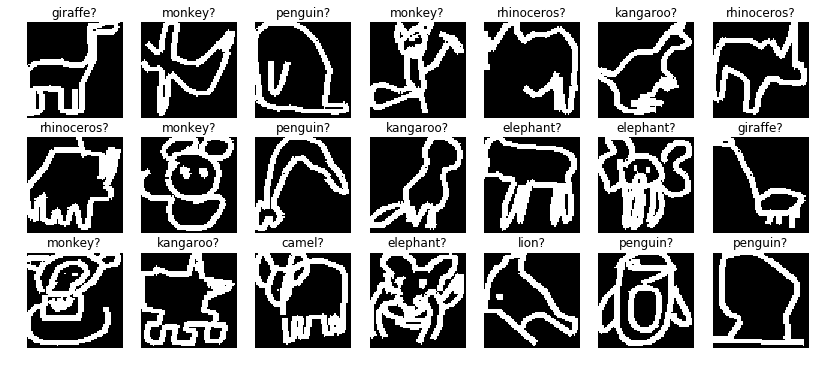

In [ ]:
# Analyze some predictions.
cols, rows = 7, 3
plt.figure(figsize=(2*cols, 2*rows))
for i in range(cols * rows):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x[i], cmap='gray')
    plt.axis('off')
    pred = linear_model.predict(x[i: i + 1])[0]
    plt.title(labels[pred.argmax()] + '?')

## 2.4 Convolutional model

Keras provides layers for convolution and maxpooling.

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Reshape(target_shape=(64, 64, 1), input_shape=(64, 64)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(10, 10), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4,4)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4,4)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(labels), activation='softmax'),
])

# YOUR ACTION REQUIRED:
# Compile + print summary of model (analogous to linear model above)
conv_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.categorical_accuracy])

conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        3232      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

In [ ]:
# Path where data will be stored for visualization in TensorBoard.
# We have already started TensorBoard in the "Start TensorBoard & tunnel"
# section. Go back to that section and open the link to open TensorBoard in a
# separate tab if you have not yet done so.

# You can also run this section multiple times specifying different values for
# "tensorboard_path" -- TensorBoard allows you to compare the different runs.
tensorboard_path = './tensorboard/' + time.strftime('%H:%M', time.localtime(time.time()))
os.makedirs(tensorboard_path, exist_ok=True)

# That's also the name that will be displayed in TensorBoard:
tensorboard_path

# This callback will make Keras record loss and metrics.
# You can check out other callbacks here : https://keras.io/callbacks/
# They can do useful stuff like 
callbacks = [
    tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_path, update_freq='batch'),
]

'./tensorboard/07:55'

In [ ]:
# This callback will make Keras record loss and metrics.
# You can check out other callbacks here : https://keras.io/callbacks/
# They can do useful stuff like 

callbacks = [
    tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_path, update_freq='batch'),
]

In [ ]:
# Train the model (analogous to linear model above).
# Note: You might want to reduce the number of steps if if it takes too long.
# You probably want to change the runtime type ("Runtime" menu) to GPU! If you
# change the runtime type then you will need to rerun the cells above because
# the Python kernel's state is reset.
conv_model.fit(ds_train,
               validation_data=ds_eval,
               steps_per_epoch=train_steps,
               validation_steps=eval_steps,
               epochs=3,
               callbacks=callbacks,
               verbose=True)

Epoch 1/3
  1/500 [..............................] - ETA: 3:32:45 - loss: 2.3938 - accuracy: 0.0700 - categorical_accuracy: 0.0700

W0522 07:56:06.221572 140298422253440 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.430408). Check your callbacks.


500/500 [==============================] - 43s 86ms/step - loss: 0.7610 - accuracy: 0.7458 - categorical_accuracy: 0.7458 - val_loss: 0.5325 - val_accuracy: 0.8212 - val_categorical_accuracy: 0.8212
Epoch 2/3
500/500 [==============================] - 17s 33ms/step - loss: 0.4184 - accuracy: 0.8608 - categorical_accuracy: 0.8608 - val_loss: 0.4039 - val_accuracy: 0.8650 - val_categorical_accuracy: 0.8650
Epoch 3/3
500/500 [==============================] - 17s 34ms/step - loss: 0.3262 - accuracy: 0.8901 - categorical_accuracy: 0.8901 - val_loss: 0.3758 - val_accuracy: 0.8733 - val_categorical_accuracy: 0.8733


In [ ]:
## NOTE : If you don't see an update in TensorBoard, then restart it by re-
##        executing the cell under "Start TensorBoard & tunnel". You can run
##        those cells in a separate Colab running on the same VM (i.e. using the
##        same runtime type) while the model is training in this Colab.

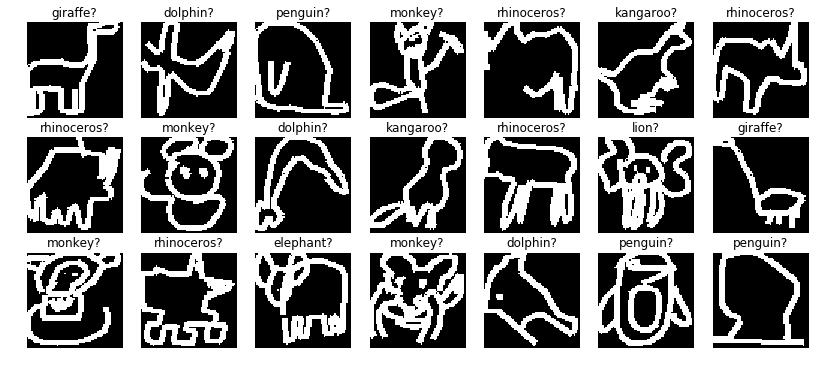

In [ ]:
# Analyze some predictions.
# Compare the errors from the convolutional model with the errors from the
# linear model...
cols, rows = 7, 3
plt.figure(figsize=(2*cols, 2*rows))
for i in range(cols * rows):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x[i], cmap='gray')
    plt.axis('off')
    pred = conv_model.predict(x[i: i + 1])[0]
    plt.title(labels[pred.argmax()] + '?')

## 2.5 Store/load model on Google Drive

All data in the local filesystem on the VM is **ephemeral**! The VM will be deleted after some time of inactivity. Two popular options for persisting data:

- Store data on some cloud storage. That's the way to got if you have large amounts of data and/or later need to access it from a cloud environment. But you also first have to register a cloud account and

In [ ]:
os.makedirs(models_path, exist_ok=True)

In [ ]:
# Save model as Keras model.
keras_path = os.path.join(models_path, 'linear.h5')
linear_model.save(keras_path)

In [ ]:
# Keras model is a single file.
!ls -hl "$keras_path"

-rw------- 1 root root 549K May 22 08:00 '/content/gdrive/My Drive/ee559/session13/models/linear.h5'


In [ ]:
model = tf.keras.models.load_model(keras_path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                45067     
Total params: 45,067
Trainable params: 45,067
Non-trainable params: 0
_________________________________________________________________


# 3 Sock competition


The models that we used in the earlier sections were intentionally kept very simple and have not been optimized at all.

In this section we will first load a dataset with some more classes to make the problem more interesting. Your task is then to develop a better model to achieve maximum accuracy ont he evaluation set.

Start with simple things (tuning batch size, learning rate, optimizer), then add more layers (batch norm, more/less convolutions). When you think you have a good combination, try increasing the training time to see where you can get.

In [80]:
## - 4.1M training examples, without pickled DataFrame
animals_data_path = 'gs://amld-datasets/animals_img'

print('https://console.cloud.google.com/storage/browser/' + animals_data_path.split('//')[1])

https://console.cloud.google.com/storage/browser/amld-datasets/animals_img


In [81]:
animals_labels = [label.strip() for label in tf.io.gfile.GFile('{}/labels.txt'.format(animals_data_path))]
print('All labels in the dataset:', ' '.join(animals_labels))

animals_counts = json.load(tf.io.gfile.GFile('{}/counts.json'.format(animals_data_path)))
print("Splits sizes:", animals_counts)

All labels in the dataset: ant bat bear bee bird butterfly camel cat cow crab crocodile dog dolphin dragon duck elephant fish flamingo frog giraffe hedgehog horse kangaroo lion lobster monkey mosquito mouse octopus owl panda parrot penguin pig rabbit raccoon rhinoceros scorpion sea turtle shark sheep snail snake spider squirrel swan
Splits sizes: {'train': 4102898, 'eval': 585810}


In [87]:
# (Uses functions defined under "2.1 Read data").
def parse_record(serialized_example):
    features = tf.io.parse_single_example(serialized_example, feature_spec)
    return (
        tf.cast(features['img_64'], tf.float32) / 255,
        tf.one_hot(features['label'], len(animals_labels)),
    )
def make_ds(which, batch_size=100):
    # The tf.io.gfile module provides transparent access to files on Gogole Cloud
    # Storage (GCS).
    ds = tf.data.TFRecordDataset(tf.io.gfile.glob('{}/{}-*'.format(animals_data_path, which)))
    ds = ds.map(parse_record).batch(batch_size)
    return ds, animals_counts[which] // batch_size

animals_ds_train, animals_train_steps = make_ds('train')
animals_ds_train = animals_ds_train.shuffle(1000).repeat()
animals_ds_eval, animals_eval_steps = make_ds('eval')

animals_train_steps, animals_eval_steps

(41028, 5858)

In [88]:
for x, y in animals_ds_train:
    break
x.shape, y.shape

(TensorShape([100, 64, 64]), TensorShape([100, 46]))

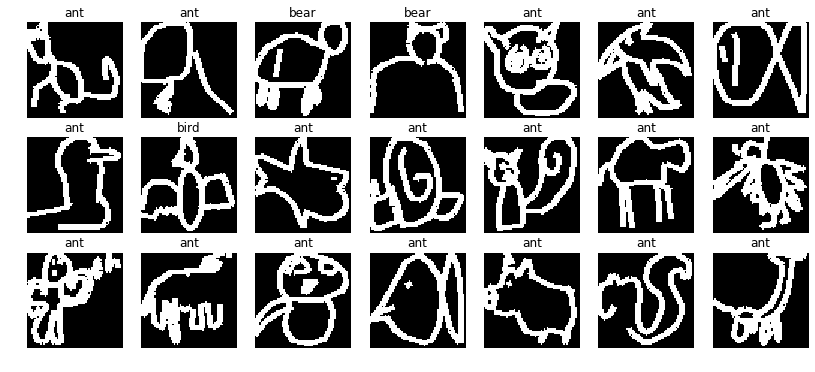

In [84]:
# Visualize some data. Note how the increased number of classes makes the
# problem considerably more complicated...
cols, rows = 7, 3
plt.figure(figsize=(2*cols, 2*rows))
for i in range(cols * rows):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x[i], cmap='gray')
    plt.axis('off')
    plt.title(animals_labels[y[i].numpy().argmax()])

In [101]:
# YOUR ACTION REQUIRED:
#
# Build a model by stacking some Keras layers. Note that using the example
# configuration from above yields already 63% accuracy (convolutional model).
#
# While waiting for training, you can walk through the bonus section below
# (make another copy of the Colab if necessary).

tensorboard_path = './tensorboard/' + time.strftime('%H:%M', time.localtime(time.time()))
os.makedirs(tensorboard_path, exist_ok=True)

# That's also the name that will be displayed in TensorBoard:
tensorboard_path

# This callback will make Keras record loss and metrics.
# You can check out other callbacks here : https://keras.io/callbacks/
# They can do useful stuff like 
callbacks = [
    tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_path, update_freq='batch'),
]
Sock_model = tf.keras.Sequential([
    tf.keras.layers.Reshape(target_shape=(64, 64, 1), input_shape=(64, 64)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(4, 4), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3,3)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3,3)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(animals_labels), activation='softmax'),
])

# YOUR ACTION REQUIRED:
# Compile + print summary of model (analogous to linear model above)
Sock_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.002),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.categorical_accuracy])

Sock_model.summary()
# Train the model (analogous to linear model above).
# Note: You might want to reduce the number of steps if if it takes too long.
# You probably want to change the runtime type ("Runtime" menu) to GPU! If you
# change the runtime type then you will need to rerun the cells above because
# the Python kernel's state is reset.


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 64, 64, 64)        1088      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)             

Train_Model

In [ ]:
# Train the model (analogous to linear model above).
# Note: You might want to reduce the number of steps if if it takes too long.
# You probably want to change the runtime type ("Runtime" menu) to GPU! If you
# change the runtime type then you will need to rerun the cells above because
# the Python kernel's state is reset.
Sock_model.fit(animals_ds_train,
               validation_data=animals_ds_eval,
               steps_per_epoch=animals_train_steps,
               validation_steps=animals_eval_steps,
               epochs=5,
               callbacks=callbacks,
               verbose=True)

Epoch 1/5
41028/41028 [==============================] - 1807s 44ms/step - loss: 0.9212 - accuracy: 0.7292 - categorical_accuracy: 0.7292 - val_loss: 0.8294 - val_accuracy: 0.7534 - val_categorical_accuracy: 0.7534
Epoch 2/5
19277/41028 [=============>................] - ETA: 11:29 - loss: 0.8147 - accuracy: 0.7577 - categorical_accuracy: 0.7577

Restart Tensorboard


In [100]:
# This cell (re)starts TensorBoard & forward the port using ngrok.

# Stop previously started processes, if any.
!pkill tensorboard; pkill ngrok
# Make sure ngrok was installed locally in previous cell.
assert os.system('./ngrok --help') == 0
# Start TensorBoard.
get_ipython().system_raw(
    'tensorboard --logdir "./tensorboard" --host 0.0.0.0 --port 6006 &'
)
# Forward port.
get_ipython().system_raw('./ngrok http 6006 &')
# Give some time to start up.
!sleep 1
# Output external address (ngrok's web interface listens at 4004).
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://ce466504.ngrok.io


In [ ]:
!rm -r ./tensorboard

# 4 Bonus: TensorFlow.js

In this section we'll convert our models from last section to TensorFlow.js models and then write a mini web site that loads the converted model for live inference.

First read a bit about basic concepts in TensorFlow.js:
https://js.tensorflow.org/tutorials/core-concepts.html

### 4.1 Basics

In [ ]:
# Getting the data of a tensor in TensorFlow.js : Use the async .data() method
# to show the output in the "output" element.
# See output in javascript console (e.g. Chrome developer tools).

# Alternatively, you can also copy'n'paste the code into a CodePen:
# https://codepen.io/andreassteiner/pen/BedqJW?editors=1011
%%html
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@0.14.1/dist/tf.min.js"></script>
<pre id="output"></pre>
<script>
  let output = document.getElementById('output')
  let t = tf.tensor([1, 2, 3])
  output.textContent = t
  // YOUR ACTION REQUIRED:
  // Use "t.data()" to append the tensor's data values to "output.textContent".


In [ ]:
# Get top 3 predictions in TensorFlow.
preds = tf.constant([0.1, 0.5, 0.2, 0.0])
topk = tf.math.top_k(preds, 3)
for idx, value in zip(topk.indices.numpy(), topk.values.numpy()):
    print('idx', idx, 'value', value)

In [ ]:
# Implement the same top 3 functionality in TensorFlow.js, showing the output
# in the "output" element.
# See https://js.tensorflow.org/api/latest/index.html#topk
%%html
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@0.14.1/dist/tf.min.js"></script>
<pre id="output"></pre>
<script>
  let output = document.getElementById('output')
  let preds = tf.tensor([0.1, 0.5, 0.2, 0.0])
  // YOUR ACTION REQUIRED:
  // Use tf.topk() to get top 3 predictions in "preds" and append both the
  // index and the value of these predictions to "output".


### 4.2 Convert Model

We can convert the Keras model into TensorFlow.js format using the Python package `tensorflowjs`.

Read more about importing Keras models:
https://js.tensorflow.org/tutorials/import-keras.html


In [ ]:
# Install extra package
!pip install -q tensorflowjs

In [ ]:
# Specify directory where to store model.
# BTW : Note the "Files" tabe on the left side (where we also have "Table of
# contents"). After executing this cell you should see the new "tfjs" directory.
tfjs_model_path = './tfjs/model'
!mkdir -p "$tfjs_model_path"

In [ ]:
# Convert model.
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(conv_model, tfjs_model_path)
!ls -lh "$tfjs_model_path"

### 4.3 Run http Server

By copying together the content of the two `%%html` cells (without the leading `%%html`!) you can now create a fully functional mini web app that handles user input and performs predictions on-device.

We store the web page in `./tfjs/index.html` and then use `python3 -m http.server` to serve both the html and the model files. The HTTP port is then forwarded to a public address using [ngrok](https://ngrok.com).

In [ ]:
# Append the content of the two html cells (without the "%%html" line) in this
# Colab below and run the cell. It will create a file "index.html" - you can
# verify this in the "Files" tab on the right.
%%writefile ./tfjs/index.html
<meta name="viewport" content="width=device-width, initial-scale=1, user-scalable=no">
<canvas width="256" height="256" id="canvas" style="border:1px solid black"></canvas><br />
<button id="clear">clear</button><br />
<pre id="output"></pre>
<script>
  window.onerror = function(msg, url, line, col, error) {
    alert("Error: " + msg + "\nurl: " + url + "\nline: " + line + '\nerror: ' + error);
  }
</script>
<script>
  let upscaleFactor = 4, halfPenSize = 2
  let canvas = document.getElementById('canvas')
  let output = document.getElementById('output')
  let ctx = canvas.getContext('2d')
  let img_64 = new Uint8Array(64*64)
  let dragging = false
  let timeout
  let predict = () => {
    google.colab.kernel.invokeFunction('amld.predict', [Array.from(img_64)], {}).then(
        obj => output.textContent = obj.data['application/json'].result)
  }
  const getPos = e => {
    let x = e.offsetX, y = e.offsetY
    if (e.touches) {
      const rect = canvas.getBoundingClientRect()
      x = e.touches[0].clientX - rect.left
      y = e.touches[0].clientY - rect.left
    }
    return {
      x: Math.floor((x - 2*halfPenSize*upscaleFactor/2)/upscaleFactor),
      y: Math.floor((y - 2*halfPenSize*upscaleFactor/2)/upscaleFactor),
    }
  }
  const handler = e => {
    const { x, y } = getPos(e)
    ctx.fillStyle = 'black'
    ctx.fillRect(x*upscaleFactor, y*upscaleFactor,
                 2*halfPenSize*upscaleFactor, 2*halfPenSize*upscaleFactor)
    for (let yy = y - halfPenSize; yy < y + halfPenSize; yy++)
      for (let xx = x - halfPenSize; xx < x + halfPenSize; xx++)
        img_64[64*Math.min(63, Math.max(0, yy)) + Math.min(63, Math.max(0, xx))] = 1
    clearTimeout(timeout)
    timeout = setTimeout(predict, 500)
  }
  canvas.addEventListener('touchstart', e => {dragging=true; handler(e)})
  canvas.addEventListener('touchmove', e => {e.preventDefault(); dragging && handler(e)})
  canvas.addEventListener('touchend', () => dragging=false)
  canvas.addEventListener('mousedown', e => {dragging=true; handler(e)})
  canvas.addEventListener('mousemove', e => {dragging && handler(e)})
  canvas.addEventListener('mouseup', () => dragging=false)
  canvas.addEventListener('mouseleave', () => dragging=false)
  document.getElementById('clear').addEventListener('click', () => {
    ctx.fillStyle = 'white'
    ctx.fillRect(0, 0, 64*upscaleFactor, 64*upscaleFactor)
    output.textContent = ''
    img_64 = new Uint8Array(64*64)
  })
</script>
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@1.0.0/dist/tf.min.js"></script>
<script>
  const labels = ["camel", "crocodile", "dolphin", "elephant", "flamingo", "giraffe", "kangaroo", "lion", "monkey", "penguin", "rhinoceros"]
  const modelPath = './model/model.json'
  let model = null
  tf.loadLayersModel(modelPath).then(response => model = response)
  predict = () => {
    const preds = model.predict(tf.tensor(img_64).reshape([1, 64, -1]))
    const { values, indices } = tf.topk(preds, 3)
    Promise.all([values.data(), indices.data()]).then(data => {
      const [ values, indices ] = data
      output.textContent = ''
      values.forEach((v, i) => output.textContent +=  `${labels[indices[i]]} : ${v.toFixed(3)}\n`)
    })
  }
</script>

In [ ]:
# Forwarding of port local http server using https://ngrok.com
# (You can skip this cell if you already downloaded ngrok under 1.3)

# Download & unzip ngrok
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip
!ls -lh ./ngrok

In [ ]:
# Make sure ngrok is downloaded.
assert os.system('./ngrok --help') == 0

# Then start a mini web server at a random port...
import random
port = random.randint(1000, 2**16)

!pkill ngrok
!kill $(ps x | grep -v grep | grep http.server | awk '{print $1}') 2>/dev/null

get_ipython().system_raw(
    'cd ./tfjs && python3 -m http.server {} &'
    .format(port)
)

# ...and forward the port using ngrok.
get_ipython().system_raw('./ngrok http {} &'.format(port))

In [ ]:
# Get the public address from localhost:4040 (ngrok's web interface).
import time, urllib
time.sleep(1)  # Give ngrok time to startup.
ngrok_data = json.load(urllib.request.urlopen('http://localhost:4040/api/tunnels'))
ngrok_data['tunnels'][0]['public_url']

Note: If you don't see any predictions, check the Browser's error console. If you see a message like "Provided weight data has no target variable" then it is likely due to weight names getting mixed up when reloading a saved model from disk. In that case, either convert a model trained in the current session - not loaded via `tf.keras.models.load_model()` - or restart the kernel and reload from disk using `tf.keras.models.load_model()`.

In [ ]:
# You can connect to this external address using your mobile phone!
# Once the page is loaded you can turn on flight modus and verify that
# predictions are really generated on-device :-)
!pip install -q qrcode
import qrcode
qrcode.make(ngrok_data['tunnels'][0]['public_url'])